## The work in this file was done to generate the right kind of blended CAPTCHA image such that it would be readable by humans and indetectable by YOLO.

In [ ]:
%%capture
!pip install ultralytics

In [3]:
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image as PilImage, ImageDraw
import os
import random
import matplotlib.pyplot as plt

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# paths
root_path = '/content/drive/My Drive/EE 5561 Course Project/'
captcha_dataset_path = os.path.join(root_path, 'new_captcha_dataset/')
high_res_background_path = os.path.join(root_path, 'new_high_res_background/')
yolo_testing_path = os.path.join(root_path, 'yolo_testing/')
final_dataset_path = os.path.join(root_path, 'final_dataset/')

os.makedirs(yolo_testing_path, exist_ok=True)
os.makedirs(final_dataset_path, exist_ok=True)

In [ ]:
# paths
# root_path = os.getcwd()
# captcha_dataset_path = os.path.join(root_path, 'new_captcha_dataset/')
# high_res_background_path = os.path.join(root_path, 'new_high_res_background/')
# yolo_testing_path = os.path.join(root_path, 'yolo_testing/')
# final_dataset_path = os.path.join(root_path, 'final_dataset/')

In [ ]:
from skimage.metrics import structural_similarity as ssim

def calculate_noise_metrics(original_image, noisy_image, win_size=3):
    """
    Calculate noise metrics between an original image and a noisy image.

    Args:
        original_image (PIL.Image): The original CAPTCHA image.
        noisy_image (PIL.Image): The noisy CAPTCHA image.
        win_size (int): Window size for SSIM (must be odd and <= image dimensions).

    Returns:
        dict: A dictionary containing RMSE, MAE, and SSIM.
    """
    # Convert images to NumPy arrays
    original_array = np.array(original_image, dtype='float32')
    noisy_array = np.array(noisy_image, dtype='float32')

    # Calculate RMSE
    rmse = np.sqrt(np.mean((original_array - noisy_array) ** 2))

    # Calculate MAE
    mae = np.mean(np.abs(original_array - noisy_array))

    # Calculate SSIM with a smaller window size
    ssim_value = ssim(
        original_array,
        noisy_array,
        multichannel=True,
        win_size=win_size,
        data_range=255,  # Specify the data range explicitly
        channel_axis=-1
    )

    return {
        "RMSE": rmse,
        "MAE": mae,
        "SSIM": ssim_value
    }


def calculate_entropy(image):
    """
    Calculate entropy of an image as a measure of noise.

    Args:
        image (PIL.Image): The image for which to calculate entropy.

    Returns:
        float: The entropy of the image.
    """
    image_array = np.array(image)
    hist, _ = np.histogram(image_array, bins=256, range=(0, 256))
    hist_normalized = hist / hist.sum()
    entropy = -np.sum(hist_normalized * np.log2(hist_normalized + 1e-10))  # Add epsilon to avoid log(0)
    return entropy

In [ ]:
def compare_noise(captcha_text):
    # Define paths and load images
    # captcha_text = "1Qgd6"  # Example CAPTCHA text
    original_image_path = os.path.join(captcha_dataset_path, f"{captcha_text}.png")

    # Load the original image
    original_image = PilImage.open(original_image_path)

    # Add noise to the original image
    noisy_image = add_fixed_noise(original_image)

    # Calculate noise metrics
    noise_metrics = calculate_noise_metrics(original_image, noisy_image, win_size=3)  # Use smaller window size for SSIM
    entropy = calculate_entropy(noisy_image)

    # Print metrics
    print(f"CAPTCHA Text: {captcha_text}")
    print(f"Noise Metrics: RMSE={noise_metrics['RMSE']:.2f}, MAE={noise_metrics['MAE']:.2f}, SSIM={noise_metrics['SSIM']:.2f}")
    print(f"Entropy: {entropy:.2f}")

In [ ]:
# noisy_images = noise_to_captcha_image(captcha_dataset_path, noise_function=add_fixed_noise)

In [ ]:
# Path to the CAPTCHA dataset
noisy_images = [
    (PilImage.open(os.path.join(captcha_dataset_path, i)), i)  # Create a tuple with the image and its filename
    for i in os.listdir(captcha_dataset_path)
]


In [ ]:
## Logic 1
def blend_captcha_with_background(captcha_text, noisy_captcha_image, background_image, opacity=255):
    """
    Blends a noisy CAPTCHA image into the center of a larger high-resolution background image.

    Args:
        captcha_text (str): The CAPTCHA text.
        noisy_captcha_image (PIL.Image): The noisy CAPTCHA image.
        background_image (PIL.Image): The high-resolution background image.
        opacity (int): Opacity level for blending (0 = fully transparent, 255 = fully opaque).

    Returns:
        PIL.Image: The blended image.
    """
    # Ensure background is in RGBA mode
    background_resized = background_image.resize((256, 256))
    background = background_resized.convert("RGBA")

    # Ensure CAPTCHA image is in RGBA mode
    noisy_captcha_image_resized = noisy_captcha_image.resize((256, 256))
    captcha_overlay = noisy_captcha_image_resized.convert("RGBA")

    # Convert images to numpy arrays for pixel-level manipulation
    captcha_array = np.array(captcha_overlay)
    background_array = np.array(background)

    # Calculate position to center the CAPTCHA overlay on the background
    bg_width, bg_height = background_array.shape[1], background_array.shape[0]
    captcha_width, captcha_height = captcha_array.shape[1], captcha_array.shape[0]
    x_offset = (bg_width - captcha_width) // 2
    y_offset = (bg_height - captcha_height) // 2

    # Blend CAPTCHA with the background
    blended_array = background_array.copy()  # Start with the background
    for y in range(captcha_array.shape[0]):  # Height of the CAPTCHA
        for x in range(captcha_array.shape[1]):  # Width of the CAPTCHA
            r, g, b, a = captcha_array[y, x]  # CAPTCHA pixel RGBA
            bg_x = x + x_offset  # Adjust x position for centering
            bg_y = y + y_offset  # Adjust y position for centering

            if r > 230 and g > 230 and b > 230:  # White pixel detected
                # Replace white pixels with the corresponding background pixel
                blended_array[bg_y, bg_x] = [
                    background_array[bg_y, bg_x][0],  # Background R
                    background_array[bg_y, bg_x][1],  # Background G
                    background_array[bg_y, bg_x][2],  # Background B
                    opacity,                          # Set opacity
                ]
            else:
                # Keep non-white CAPTCHA pixel but modify opacity
                blended_array[bg_y, bg_x] = [
                    r, g, b, max(a, opacity)  # Ensure non-white CAPTCHA is visible
                ]

In [ ]:
def blend_single_image(i, noisy_captcha_image, captcha_file_name, background_files, blending_function):
    """
    Processes a single image: blends a CAPTCHA image with a randomly chosen background image.

    Args:
        i (int): Index for the random seed.
        noisy_captcha_image (PIL.Image): The noisy CAPTCHA image.
        captcha_name (str): The CAPTCHA text.
        background_files (list): List of available background image files.
        blending_function (function): Function used for blending CAPTCHA with the background.

    Returns:
        tuple: (captcha_name, object_name, blended_image)
    """
    # Random seed for reproducibility
    random.seed(5561 + i)

    # Selecting  a background image randomly
    background_file = random.choice(background_files)
    background_image = PilImage.open(os.path.join(high_res_background_path, background_file))

    # Extract object name from the background file
    background_name = os.path.splitext(background_file)[0]  # removes extension
    object_name = background_name.split('_')[0]  # Last word (e.g., "truck")

    # Blending CAPTCHA with background
    blended_image = blending_function(
        captcha_file_name, noisy_captcha_image, background_image, opacity=255
    )

    # Saving the blended image
    captcha_text = captcha_file_name.split('.')[0]
    output_filename = f"{captcha_text}_{object_name}.png"
    output_path = os.path.join(final_dataset_path, output_filename)
    blended_image.save(output_path)

    return captcha_text, object_name, blended_image

In [7]:
from joblib import Parallel, delayed
from tqdm import tqdm

def main(blending_function, captcha_images, n_jobs=-1):
    """
    Main function to process all images in parallel using joblib.

    Args:
        blending_function (function): Function used for blending CAPTCHA with the background.
        captcha_images (list): List of tuples (noisy_captcha_image, captcha_name).
        n_jobs (int): Number of parallel jobs. Default is -1 (use all CPUs).

    Returns:
        list: List of tuples containing the CAPTCHA name, object name, and blended image.
    """
    # Get all background files from high_res_background_path
    background_files = [f for f in os.listdir(high_res_background_path) if f.endswith('.png')]

    # Use Parallel to process images in parallel
    blended_images = Parallel(n_jobs=-1)(
        delayed(blend_single_image)(i, noisy_captcha_image, captcha_name, background_files, blending_function)
        for i, (noisy_captcha_image, captcha_name) in enumerate(tqdm(captcha_images, desc="Processing CAPTCHA Images"))
    )

    return blended_images

In [ ]:
%%time
blended_images = main(blend_captcha_with_background, noisy_images)



Processing CAPTCHA Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing CAPTCHA Images:   0%|          | 4/1000 [00:01<07:13,  2.30it/s]

Processing CAPTCHA Images:   1%|          | 6/1000 [00:02<08:23,  1.97it/s]

Processing CAPTCHA Images:   1%|          | 8/1000 [00:04<08:46,  1.88it/s]

Processing CAPTCHA Images:   1%|          | 10/1000 [00:05<08:58,  1.84it/s]

Processing CAPTCHA Images:   1%|          | 12/1000 [00:06<09:48,  1.68it/s]

Processing CAPTCHA Images:   1%|▏         | 14/1000 [00:08<11:47,  1.39it/s]

Processing CAPTCHA Images:   2%|▏         | 16/1000 [00:10<13:04,  1.25it/s]

Processing CAPTCHA Images:   2%|▏         | 18/1000 [00:12<13:17,  1.23it/s]

Processing CAPTCHA Images:   2%|▏         | 20/1000 [00:13<12:05,  1.35it/s]

Processing CAPTCHA Images:   2%|▏         | 22/1000 [00:14<11:14,  1.45it/s]

Processing CAPTCHA Images:   2%|▏         | 24/1000 [00:15<10:41,  1.52it/s]

Processing CAPTCHA Images:   3%|▎         | 26/1000 [00:16<10:12,  1.59it/

CPU times: user 19.4 s, sys: 1.99 s, total: 21.4 s
Wall time: 11min 16s


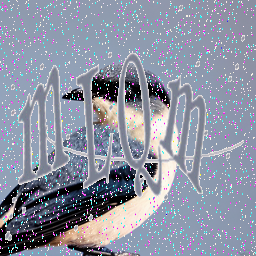

In [ ]:
blended_images[0][-1]

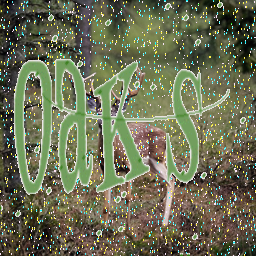

In [ ]:
blended_images[4][-1]

In [14]:
os.listdir(final_dataset_path)[2]

'4Fb5_ship.png'

(-0.5, 255.5, 255.5, -0.5)

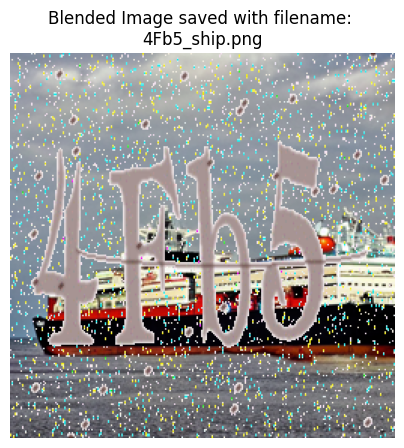

In [16]:
plt.figure(figsize=(5, 5))

plt.imshow(np.array(PilImage.open(os.path.join(final_dataset_path, os.listdir(final_dataset_path)[2]))))
plt.title('Blended Image saved with filename: \n4Fb5_ship.png')
plt.axis('off')

In [ ]:
# Function to denoise image using Non-Local Means to test the effect of possible denoising applied by CAPTCHA solvers to
def denoise_image(image):
  """Denoises an RGB image using OpenCV's non-local means denoising.

  Args:
    image_path: Path to the image file.

  Returns:
    Denoised image as a NumPy array.
  """

  # Read the image
  img = np.array(image)

  # Apply non-local means denoising
  denoised_img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

  return PilImage.fromarray(denoised_img)

## YOLOv8 model

In [ ]:
# YOLOv8 model
model = YOLO("yolov8m.pt")

In [ ]:
%%capture
# Counters for correct and wrong predictions
correct = 0
wrong = 0

# Lists to store images and details
correct_predictions = []  # List of tuples (captcha_text, object_name, blended_image, detected_classes)
wrong_predictions = []    # List of tuples (captcha_text, object_name, blended_image, detected_classes)

# Iterating over blended images
for i in blended_images:
    # Extract the blended image and expected object name
    captcha_text, object_name, blended_image = i

    # check results after denoising images
    blended_image = denoise_image(blended_image)

    # Run the YOLO model on the blended image
    results = model(blended_image)How

    # Parse YOLO results to get the predicted class names
    detected_classes = [model.names[int(box.cls)] for box in results[0].boxes]

    # Check if the expected object name matches any detected class
    if object_name in detected_classes:
        correct += 1
        correct_predictions.append((captcha_text, object_name, blended_image, detected_classes))
    else:
        wrong += 1
        wrong_predictions.append((captcha_text, object_name, blended_image, detected_classes))


0: 640x640 (no detections), 1860.8ms
Speed: 7.7ms preprocess, 1860.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bench, 1 chair, 1 vase, 1562.1ms
Speed: 6.7ms preprocess, 1562.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 vases, 2291.0ms
Speed: 5.8ms preprocess, 2291.0ms inference, 12.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 scissorss, 2456.5ms
Speed: 4.3ms preprocess, 2456.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scissors, 2317.9ms
Speed: 4.2ms preprocess, 2317.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scissors, 2539.5ms
Speed: 10.0ms preprocess, 2539.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1544.7ms
Speed: 5.9ms preprocess, 1544.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 scissorss, 1516.5ms
Speed: 3.2ms preprocess, 

In [ ]:
# results
print(f"Correct Predictions: {correct}")
print(f"Wrong Predictions: {wrong}")

Correct Predictions: 1
Wrong Predictions: 49


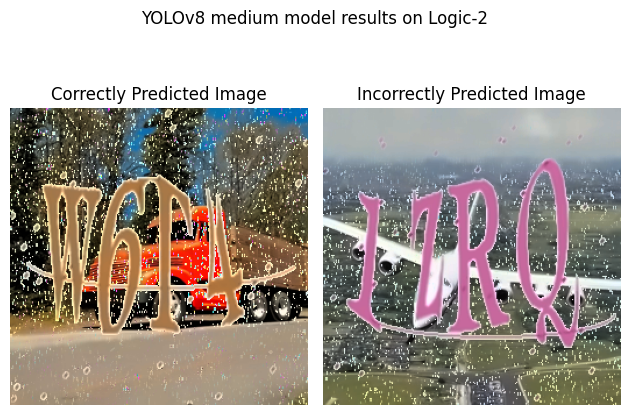

In [ ]:
plt.subplots(1,2)

plt.subplot(1,2,1)
plt.imshow(correct_predictions[0][2])
plt.title('Correctly Predicted Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wrong_predictions[3][2])
plt.title('Incorrectly Predicted Image')
plt.axis('off')

plt.suptitle('YOLOv8 medium model results on Logic-2')
plt.tight_layout()

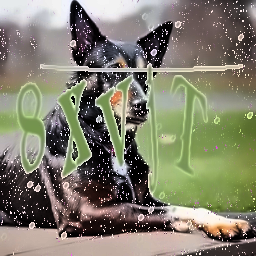

In [ ]:
denoise_image(blended_images[9][-1])

In [ ]:
model(denoise_image(blended_images[0][-1]))


0: 640x640 (no detections), 2580.9ms
Speed: 4.5ms preprocess, 2580.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p